### CPS Age Cohorts Example

In [1]:
%config Completer.use_jedi = False
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

mpl.rcParams['legend.framealpha'] = 1
mpl.rcParams['legend.title_fontsize'] = 12
mpl.rcParams['legend.fontsize'] = 11

os.chdir('/home/brian/Documents/CPS/data/clean/')

In [2]:
col = ['YEAR', 'MONTH', 'AGE', 'FEMALE', 'BASICWGT', 'LFS']

yob = lambda x: x.YEAR - x.AGE

emp = lambda x: np.where(x.LFS == 'Employed', 1, 0)
emprt = lambda x: np.average(x.EMP, weights=x.BASICWGT)

d = {}
for name, i in [('Men', 0), ('Women', 1)]:
    data = (pd.concat([pd.read_feather(f'cps{year}.ft', columns=col) 
                       for year in range (1989, 2022)])
              .query('18 <= AGE <= 64 and FEMALE == @i')
              .assign(YOB = yob, EMP = emp))

    data['Generation'] = pd.cut(data.YOB, 
                         [1900, 1927, 1945, 1964, 1980, 1996, 2012],
                         labels=['Greatest', 'Silent', 'Boomers', 
                                 'Gen X', 'Milennials', 'Zoomers'])
    groups = ['Generation', 'AGE']

    d[name] = data.groupby(groups).apply(emprt).unstack().T * 100

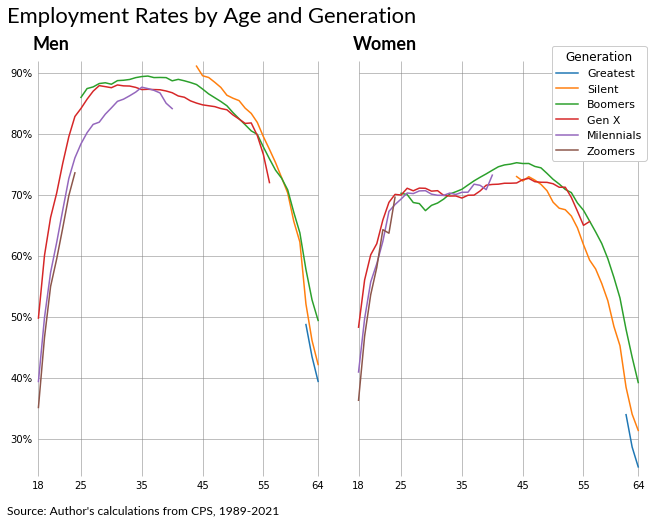

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, 
                               constrained_layout=True)

fig.set_figheight(6.5)
fig.set_figwidth(9.0)
for ax, cat, legend in [(ax1, 'Men', False), (ax2, 'Women', True)]:
    d[cat].plot(ax=ax, legend=legend)
    ax.text(17, 94, cat, size=18, fontname='Lato', weight='bold')
    for y_val in [30, 40, 50, 60, 70, 80, 90]:
        ax.hlines(y=y_val, xmin=18, xmax=64, 
                  linewidth=0.5, color='gray', zorder=0)
        if ax == ax1:
            ax.text(17, y_val-0.5, f'{y_val}%', ha='right')
    for age_val in [18, 25, 35, 45, 55, 64]: 
        ax.vlines(x=age_val, ymin=24, ymax=92, 
                  linewidth=0.5, color='gray', zorder=0)
        ax.text(age_val, 22, f'{age_val}', ha='center')
    ax.axis('off')
fig.text(0, 1.02, 'Employment Rates by Age and Generation', 
         size=22, fontname='Lato')
fig.text(0, -0.03, "Source: Author's calculations from CPS, 1989-2021", 
         size=12, fontname='Lato');